<a href="https://colab.research.google.com/github/InutilemMachina/DataSciRepo/blob/main/EnsembleMethods_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Methods

- Voting: parallel machines votes
- Bagging & Pasting: the same machine is trained on different subsets, sampled with- (bagging) or without (pasting) replacement.
- Random forests: an ensemble of decision forests typicall trained with bagging.
- Boosting: Series of the same type of machine continuously fitting better models.
- Stacking: different machines take their on bets. A *super-machine* (hierarchically higher) makes their prediction on sub-predicitons. This *super-machine* is called *blender* or *meta-learner*.

## Voting classifiers

`VotingClassifier`: accepts name-predictor pairs and simply use as a normal classifier

In [ ]:
#make some data
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples = 100, noise=0.30, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

voter_clf = VotingClassifier(
    estimators = [
        ('log_reg',        LogisticRegression(random_state = 0)),
        ('rand_forest',   RandomForestClassifier(random_state = 0)),
        ('svm_clf',        SVC(random_state = 0))
    ]
)

voter_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression(random_state=0)),
                             ('rand_forest',
                              RandomForestClassifier(random_state=0)),
                             ('svm_clf', SVC(random_state=0))])

In [ ]:
#access elements
voter_clf.named_estimators_
voter_clf.named_estimators_.items()

dict_items([('log_reg', LogisticRegression(random_state=0)), ('rand_forest', RandomForestClassifier(random_state=0)), ('svm_clf', SVC(random_state=0))])

In [ ]:
# test scores on test set
voter_clf.named_estimators_['log_reg']
voter_clf.named_estimators_['log_reg'].score(X_test, y_test)
voter_clf.named_estimators_['rand_forest']
voter_clf.named_estimators_['rand_forest'].score(X_test, y_test)
voter_clf.named_estimators_['svm_clf']
voter_clf.named_estimators_['svm_clf'].score(X_test, y_test)

0.92

In [ ]:
# elegantly:
for name, clf in voter_clf.named_estimators_.items():
    print(name + ' score = ' + str(clf.score(X_test, y_test)))

log_reg score = 0.84
rand_forest score = 0.96
svm_clf score = 0.92


In [ ]:
# the overall score
voter_clf.score(X_test, y_test)

0.92

In [ ]:
# make a predicition
voter_clf.predict(X_test[:1])

array([0])

In [ ]:
# look at individual predicitons
[clf.predict(X_test[:1]) for clf in voter_clf.estimators_]

[array([0]), array([0]), array([0])]

If each classifier in the line has a `predict_proba` method, than `voting = 'soft'`  hyperparam is available.

Each classifier predicts the probability of each class label, and the probabilities are summed across all classifiers. The class label with the highest sum of probabilities is then predicted as the final output.

*Soft voting* is recommended for an ensemble of well-calibrated classifiers, where the probability output of each classifier can be interpreted as a confidence level.

In [ ]:
voter_clf = VotingClassifier(
    estimators = [
        ('log_reg',        LogisticRegression(random_state = 0)),
        ('rand_forest',   RandomForestClassifier(random_state = 0)),
        ('svm_clf',        SVC(random_state = 0, probability=True))  # SVC by default does not provide predict_proba method
    ],
    voting = 'soft'
)

voter_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression(random_state=0)),
                             ('rand_forest',
                              RandomForestClassifier(random_state=0)),
                             ('svm_clf',
                              SVC(probability=True, random_state=0))],
                 voting='soft')

In [ ]:
voter_clf.score(X_test, y_test)

0.92

## Bagging & Pasting

Above we've seen how different classifiers can be used on the same training set.

The following approaches utilise one classifier trained on different subsets of the training set.

When sampling is done **with** replacement, we speak about *bagging*.

When sampling is done **without** replacament, we call it *pasting*.

The most frequent prediction (i.e. the mode) will be predicted. [In case of regression, the average.] This is a *hard voting* model, but a `BaggingClassifier ` automatically performs *soft voting* if the base classifier can estimate class probabilities
(i.e., if it has a `predict_proba()` method), which is the case with `DecisionTreeClassifiers`.

In [ ]:
#make some data
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples = 500, noise=0.30, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators= 500,  # number of decision tree classifiers *
    max_samples= 100,  # each trained on 100 samples
    n_jobs = -1,  # number of CPU cores to use
    bootstrap=True,  # if True: bagging; if Fale: pasting
    random_state=0
)

# *  max_samples can alternatively be set to a float between 0.0 and 1.0,
#    in which case the max number of sampled instances is equal
#    to the size of the training set times max_samples (train_size*float).
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=0)

In [ ]:
# for comparison:
tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf.fit(X_train, y_train)

Text(0.5, 1.0, 'DecisionTreeClassifier')

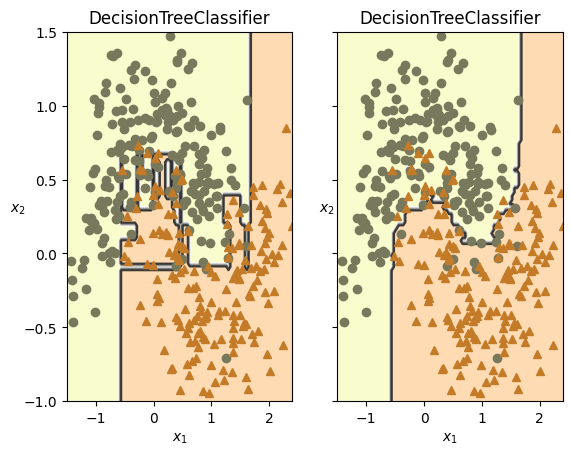

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, sharey=True)
plt.sca(ax[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title('DecisionTreeClassifier')

plt.sca(ax[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title('DecisionTreeClassifier')

### Out-of-bag evaluation

Bootstrapping (resampling with replacement) touches on average only 63% of samples, thus 37% is never seen. We call them OOB, out-of-bag samples. This makes it possible to validate the classifier without an externalized validation set, but using the inherent OOB samples, setting `oob_score=True`

    bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    oob_score=True,
    n_jobs=-1,
    random_state=0)

    bag_clf.fit(X_train, y_train)
    bag_clf.oob_score_

In [ ]:
### Random Patches and Random Subspaces

## Random Forests
An ensemble of decision trees. When building trees, the random forest algorithm adds additional randomization; when splitting a node, it looks for the best feature among a random selection of features rather than the very best feature.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=0)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

### Extremely randomized trees
Only a random subset of the features are taken into account for splitting at each node when building a tree in a random forest (as was previously discussed). Instead of looking for the best possible thresholds (like standard decision trees do), it is feasible to further randomize trees by applying random thresholds for each feature. Simply provide `splitter='random'` when building a `DecisionTreeClassifier` to do this.

In [ ]:
### Feature Importance

## Boosting
instead of a bucket of parallel learners, we build a series of learners. In this series, each learner corrects/improves the prediction of the preceding learner.

### AdaBoost
in the series each machine put a little more weight on the previously underfitted, misclassified instances. We say, *the weigths of misclassified instances gets boosted*.

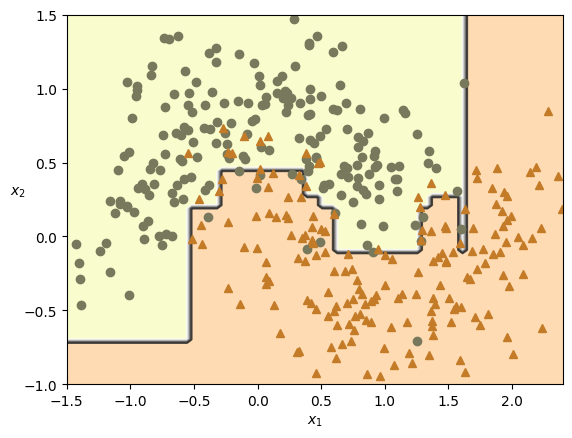

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,  # The maximum number of estimators
    learning_rate=0.5,  # Weight applied to each classifier at each boosting iteration
    random_state=0)

ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X_train, y_train)

### Gradient Boosting
instead of increasing wieghts, it fits new predictors to the residuals.

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(0)
X = np.random.rand(500, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(500)

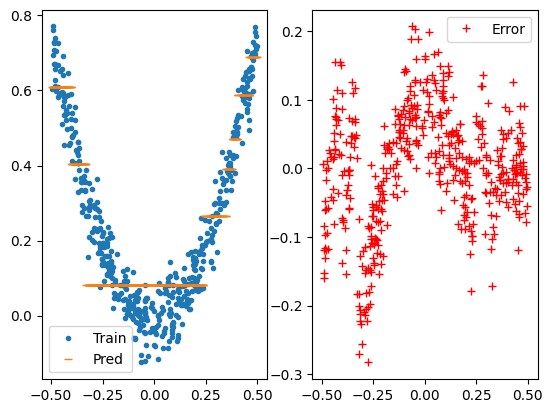

In [ ]:
tree_reg_1 = DecisionTreeRegressor(max_depth=3, random_state=0)
tree_reg_1.fit(X, y)

# x_new = np.linspace(-0.5,0.5,100)
x_new = np.sort(X)
y_pred_1 = tree_reg_1.predict(x_new.reshape(-1,1))
residuals_1 = y_pred_1 - y

fig, ax = plt.subplots(1,2)
ax[0].plot(X,y,'.', label = 'Train')
ax[0].plot(x_new, y_pred_1, '_', label = 'Pred')
ax[0].legend()
ax[1].plot(x_new,residuals_1,'r+', label = 'Error')
plt.legend()

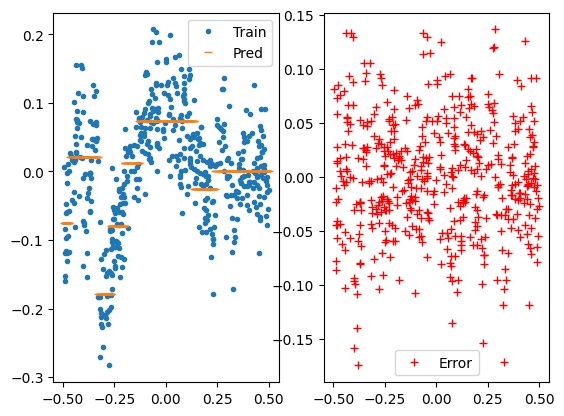

In [ ]:
tree_reg_2 = DecisionTreeRegressor(max_depth=3, random_state=1)
tree_reg_2.fit(X, residuals_1)

# x_new = np.linspace(-0.5,0.5,100)
y_pred_2 = tree_reg_2.predict(x_new.reshape(-1,1))
residuals_2 = residuals_1 - y_pred_2

fig, ax = plt.subplots(1,2)
ax[0].plot(X,residuals_1,'.', label = 'Train')
ax[0].plot(x_new, y_pred_2,'_', label = 'Pred')
ax[0].legend()
ax[1].plot(x_new,residuals_2,'r+', label = 'Error')
plt.legend()

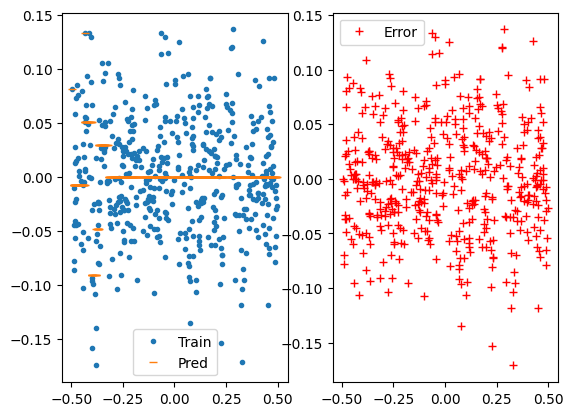

In [ ]:
tree_reg_3 = DecisionTreeRegressor(max_depth=3, random_state=2)
tree_reg_3.fit(X, residuals_2)

# x_new = np.linspace(-0.5,0.5,100)
y_pred_3 = tree_reg_3.predict(x_new.reshape(-1,1))
residuals_3 = residuals_2 - y_pred_3

fig, ax = plt.subplots(1,2)
ax[0].plot(X, residuals_2,'.', label = 'Train')
ax[0].plot(x_new, y_pred_3,'_', label = 'Pred')
ax[0].legend()
ax[1].plot(x_new,residuals_3,'r+', label = 'Error')
plt.legend()

In [ ]:
# predict a new instance
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([-0.14242718,  0.57685052, -0.6796158 ])

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr1 = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=1.0,  #  high rate-> few tree, but will generalize worse
    n_estimators=3,
    random_state=0)

gbr1.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=0)

In [ ]:
gbr2 = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=0.05,  #  low rate-> more tree is necessary, but will generalize better
    n_estimators = 500,  # but  There is a trade-off between learning_rate and n_estimators
    random_state=0)

gbr2.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          random_state=0)

Text(0.5, 0.98, 'GradientBoostingRegressor')

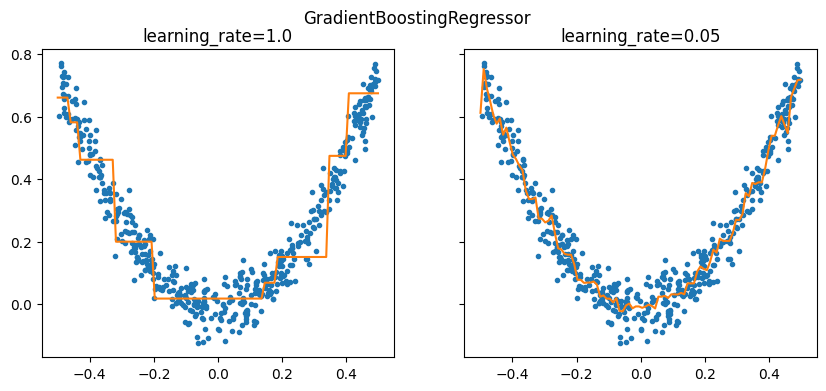

In [ ]:
x_new = np.linspace(-0.5, 0.5, 100)
y_pred_1 = gbr1.predict(x_new.reshape(-1, 1))
y_pred_2 = gbr2.predict(x_new.reshape(-1, 1))

fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
ax[0].plot(X[:, 0], y,'.')
ax[0].plot(x_new, y_pred_1)
ax[0].set_title('learning_rate=1.0, n_estimators=3')

ax[1].plot(X[:, 0], y,'.')
ax[1].plot(x_new, y_pred_2)
ax[1].set_title('learning_rate=0.05, n_estimators = 500')
plt.suptitle('GradientBoostingRegressor')

Here the situation is quite funny, b.c. we would expect a better generalization form a lower learning rate, but the fig. on the right obviously overfitted the situation. Thus we look after objective measures.

`n_iter_no_change` is used to decide if early stopping will be used to terminate training when validation score is not improving. By default it is set to `None` to disable early stopping. If set to a number, it will set aside `validation_fraction` size of the training data as validation and terminate training when validation score is not improving in all of the previous `n_iter_no_change` numbers of iterations. Values must be in the range [1, inf). (We could have used gridsearch or other hyperparam search methods, but this is way simpler.)

In [ ]:
gbr_best = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=0.05,
    n_estimators=500,
    n_iter_no_change=10,  # *
    random_state=0
    )

gbr_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=0)

Text(0.5, 1.0, 'learning_rate=0.05,n_estimators=500,n_iter_no_change=10')

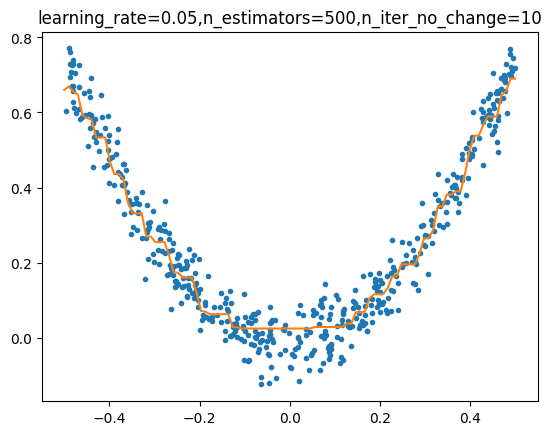

In [ ]:
y_pred_best = gbr_best.predict(x_new.reshape(-1, 1))
plt.plot(X[:, 0], y,'.')
plt.plot(x_new, y_pred_best)
plt.title('learning_rate=0.05,n_estimators=500,n_iter_no_change=10')

### Histogram-based boosting
*Histogram-based Gradient Boosting Regression Tree.*

It is quite a gem with nice features and some peculiarities.
- It bins the input features, by replacing them with integers with the `max_bins` hyperparam having default and max value of 255.
    - This reduces the number of possible tresholds to be evaluated.
    - integer computations are way-more efficient.
    - Bins let avoid sorting.

- Binning may cause:
    - regularization :) with precision loss :(
    - reduce overfitting :), may cause underfitting :(

- early stopping is autmatically active,
- subsampling is not supported,
- `max_iter` is the name of `n_estimators`
- hyperparameters: `max_leaf_nodes, min_samples_leaf, max_depth`

- supports categorical features, after using `OrdinalEncoder`
- supports missing values.

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = HistGradientBoostingRegressor(random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean squared error: {mse:.2f}")

Mean squared error: 0.22


## Stacking
Different machines take their on bets. A *super-machine* (hierarchically higher) makes their prediction on sub-predicitons. This *super-machine* is called *blender* or *meta-learner*.

Under the hood:
- to train the blender, you need a blender training set.
- You use `cross_val_predict` on every sub-machine to get out-of-sample prediction for each instance in the original traning set.
- these are the input features for the blender, whereby the targets are simple copies of the original target labels/values.
- to finish, the blender is trained and sub-machines are retrained one last time on the full original training.

Hereunder, a StackingClassifier and a StackingRegressor will be introduced


### StackingRegressor

In [ ]:
# we use here the above california set.
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

clf = StackingRegressor(
    estimators = [
    ('rf', RandomForestRegressor(n_estimators=10, random_state=0)),
    ('lr', LinearRegression())
],
    final_estimator=RandomForestRegressor(n_estimators=10, random_state=0)
)

clf.fit(X_train, y_train)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(n_estimators=10,
                                                     random_state=0)),
                              ('lr', LinearRegression())],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=0))

In [ ]:
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean squared error: {mse:.2f}")

Mean squared error: 0.37


### StackingClassifier

In [ ]:
# data for classification
from sklearn.datasets import load_wine
data = load_wine()
X = data.data
y = data.target

In [ ]:
from sklearn.ensemble import StackingClassifier

stack_clf = StackingClassifier(
    estimators = [
        ('log_reg', LogisticRegression()),
        ('rand_for', RandomForestClassifier()),
        ('svc', SVC(probability = True))  # by default it does not provide prob.s
    ],
    final_estimator = RandomForestClassifier(),
    cv = 5  # for cross-validations
)

stack_clf.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  options={"iprint": iprint, "gtol": tol, "maxiter": max_iter},
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

StackingClassifier(cv=5,
                   estimators=[('log_reg', LogisticRegression()),
                               ('rand_for', RandomForestClassifier()),
                               ('svc', SVC(probability=True))],
                   final_estimator=RandomForestClassifier())